In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
def importdata():
    loan_data = pd.read_csv('Data/merged_data.csv', sep= ',')
    loan_data = loan_data.drop('Unnamed: 0', axis=1)
      
    # Printing the dataswet shape
    print ("Dataset Length: ", len(loan_data))
    print ("Dataset Shape: ", loan_data.shape)
      
    # Printing the dataset obseravtions
    print ("Dataset: ",loan_data.head())
    return loan_data

In [3]:
merge_df = importdata()

Dataset Length:  29996
Dataset Shape:  (29996, 12)
Dataset:     client_nr  total_nr_trx  nr_debit_trx  volume_debit_trx  nr_credit_trx  \
0          1            97            50           6527929             47   
1          1            88            59           3475918             29   
2          1            96            62          31316405             34   
3          1            83            53          18669967             30   
4          1            94            54           2893905             40   

   volume_credit_trx  min_balance  max_balance  CRG  yearmonth2  \
0            7454863     -7914288     25110651  1.0  2014-01-01   
1            1895848     -8448513     25036651  1.0  2014-02-01   
2           20083583    -10347650     18020151  1.0  2014-03-01   
3            1091295    -15385039     13318200  1.0  2014-04-01   
4            2034075    -15682170      2350000  1.0  2014-05-01   

   credit_application  nr_credit_applications  
0                   0    

## 3. Feature Engineering

### 3.1 Dummy variable

In [4]:
def dummyit(data, var):
    return pd.get_dummies(data, dummy_na=False, columns=var)

In [6]:
crg_dummy_df = dummyit(merge_df, var=['CRG'])
crg_dummy_df.head(5)

,client_nr,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,yearmonth2,credit_application,nr_credit_applications,CRG_1.0,CRG_2.0,CRG_3.0,CRG_4.0,CRG_5.0,CRG_7.0
0,1,97,50,6527929,47,7454863,-7914288,25110651,2014-01-01,0,0,1,0,0,0,0,0
1,1,88,59,3475918,29,1895848,-8448513,25036651,2014-02-01,0,0,1,0,0,0,0,0
2,1,96,62,31316405,34,20083583,-10347650,18020151,2014-03-01,0,0,1,0,0,0,0,0
3,1,83,53,18669967,30,1091295,-15385039,13318200,2014-04-01,0,0,1,0,0,0,0,0
4,1,94,54,2893905,40,2034075,-15682170,2350000,2014-05-01,0,0,1,0,0,0,0,0


### Debt to Income ratio calculation

### 3.2 Scaling variables to similar scale

In [7]:
# Function to split the dataset
def splitdataset(data):
  
    # Separating the target variable
    data = data.drop(['client_nr', 'yearmonth2'], axis=1)
    X = data.loc[:, data.columns != 'credit_application']
    y = data.loc[:, data.columns == 'credit_application']
  
    # Splitting the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size = 0.3, random_state = 100)
      
    return X, y, X_train, X_test, y_train, y_test

In [13]:
# Function to standardize features
# ['nr_credit_applications', 'CRG_1.0', 'CRG_2.0', 'CRG_3.0', 'CRG_4.0', 'CRG_5.0', 'CRG_7.0']

def standardization(data, excl_var=None):
    temp = data.drop(excl_var, axis=1)
    scale_features = temp.columns
    tobe_scaled_df = data[scale_features]
    scaler = StandardScaler().fit(tobe_scaled_df.values)
    scaled = scaler.transform(tobe_scaled_df.values)
    data[scale_features] = scaled
    return data

In [16]:
X, Y, X_train, X_test, y_train, y_test = splitdataset(crg_dummy_df)
X_train_sc = standardization(X_train, excl_var=['nr_credit_applications', 'CRG_1.0', 'CRG_2.0', 'CRG_3.0', 'CRG_4.0', 'CRG_5.0', 'CRG_7.0'])
X_test_sc = standardization(X_test, excl_var=['nr_credit_applications', 'CRG_1.0', 'CRG_2.0', 'CRG_3.0', 'CRG_4.0', 'CRG_5.0', 'CRG_7.0'])

### 3.3 Oversampling to balance target variable
#### Strategy: 
*Oversample on training dataset only to train the model equally on both classes of target variable. Do not oversample the test dataset to avoid information leak from test dataset to create synthetic datapoints*

##### SMOTE high-level understanding:
* Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations

##### SMOTE vs Random oversampler?
Random oversampling just randomly samples the minority class and simply duplicates the observations. Wherease, in SMOTE the minority class is sampled based on interpolation between available observations in the original dataset, resulting in more realistic sampled data

In [19]:
def oversampling(X, y, method="random", random_state=0):
    if method == "random":
        ros = RandomOverSampler(random_state=random_state)
        ros_X_train, ros_y_train = ros.fit_resample(X, y)
        print('Original dataset shape %s' % Counter(y['credit_application']))
        print('Resampled dataset shape %s' % Counter(ros_y_train['credit_application']))
        return ros_X_train, ros_y_train
    
    if method == "smote":
        columns = X.columns
        os = SMOTE(random_state=random_state)
        os_X_train, os_y_train = os.fit_resample(X, y)
        print('Original dataset shape %s' % Counter(y['credit_application']))
        print('Resampled dataset shape %s' % Counter(os_y_train['credit_application']))
        os_data_X = pd.DataFrame(data=os_X_train,columns=columns)
        os_data_y= pd.DataFrame(data=os_y_train,columns=['credit_application'])
        return os_data_X, os_data_y

In [20]:
ros_X_train, ros_y_train = oversampling(X_train_sc, y_train, method="random")
os_X_train, os_y_train = oversampling(X_train_sc, y_train, method="smote")

Original dataset shape Counter({0: 19535, 1: 1462})
Resampled dataset shape Counter({0: 19535, 1: 19535})
Original dataset shape Counter({0: 19535, 1: 1462})
Resampled dataset shape Counter({0: 19535, 1: 19535})


### 3.4 RFE (Recursive Feature Elimination)

#### Purpose: 
Recursively select set of features and eliminate the least important features iteratively

In [21]:
logreg_model = LogisticRegression()

rfe = RFE(logreg_model, n_features_to_select=10)
rfe = rfe.fit(os_X_train, os_y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False  True False  True False False  True  True  True  True  True  True
  True  True]
[5 1 4 1 3 2 1 1 1 1 1 1 1 1]


In [22]:
rfe_cols_ros = ['nr_debit_trx', 'nr_credit_trx', 'min_balance', 'nr_credit_applications', 'CRG_1.0', 
            'CRG_2.0', 'CRG_3.0', 'CRG_4.0', 'CRG_5.0', 'CRG_7.0']

rfe_cols_os = ['nr_debit_trx', 'nr_credit_trx', 'min_balance', 'nr_credit_applications', 'CRG_1.0', 
            'CRG_2.0', 'CRG_3.0', 'CRG_4.0', 'CRG_5.0', 'CRG_7.0']

## 4. Model implementation

### 4.1 GLM for variable significance

In [25]:
X_rfe = os_X_train[rfe_cols_os]
y_rfe = os_y_train['credit_application']

In [26]:
res=sm.GLM(y_rfe, X_rfe, family=sm.families.Binomial()).fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     credit_application   No. Observations:                39070
Model:                            GLM   Df Residuals:                    39060
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1610.6
Date:                Thu, 18 Aug 2022   Deviance:                       3221.2
Time:                        00:11:02   Pearson chi2:                 4.63e+15
No. Iterations:                    30   Pseudo R-squ. (CS):             0.7285
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
nr_debit_trx               0

In [27]:
final_features = ['nr_debit_trx', 'nr_credit_trx', 'min_balance']
X_train_new = X_rfe[final_features]
X_test_new = X_test_sc[final_features]

### 4.2 Logistic Regression Model Fitting

In [28]:
logreg = LogisticRegression()
logreg.fit(X_train_new, y_rfe.values.ravel())
y_pred = logreg.predict(X_test_new)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_new, y_test)))

Accuracy of logistic regression classifier on test set: 0.66


In [31]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[5657 2779]
 [ 271  292]]


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.67      0.79      8436
           1       0.10      0.52      0.16       563

    accuracy                           0.66      8999
   macro avg       0.52      0.59      0.47      8999
weighted avg       0.90      0.66      0.75      8999



__Note:__

Model must be able to identify most of the people who will apply for loan renewal, i.e., minimize FN. Basically model should be able to identify most TP's, which means high recall is required.

*Precision*: The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative

*Recall*: The recall is intuitively the ability of the classifier to find all the positive samples

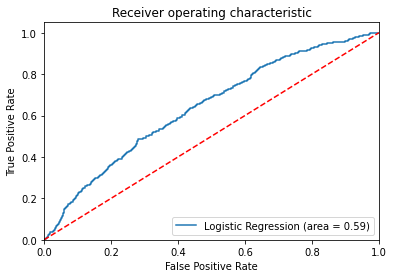

In [35]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_new)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()